In [1]:
import os
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq
from mtmkl.signalprocessing.filter_artifacts import PreProcessing, remove_edges
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mtmkl.signalprocessing.wavelet_transform import CWTTransform
from mtmkl.signalprocessing import prewhitening_strategies
from mtmkl.signalprocessing.kernel_function import correlation, phaselockingvalue, fourier_corr

%matplotlib inline

In [2]:
path = "/home/vanessa/DATA_SEEG/PKL_FILE/"
id_list = os.listdir(path)
datafile = "data.pkl"
sampling_freq=1e3

In [3]:
df = pd.read_pickle(join(path, id_list[0], datafile))
strcol = np.where([isinstance(k, str) for k in df.keys()])[0]

In [4]:
df = df.iloc[:,:strcol[0]]

In [5]:
idx = 0  # channel

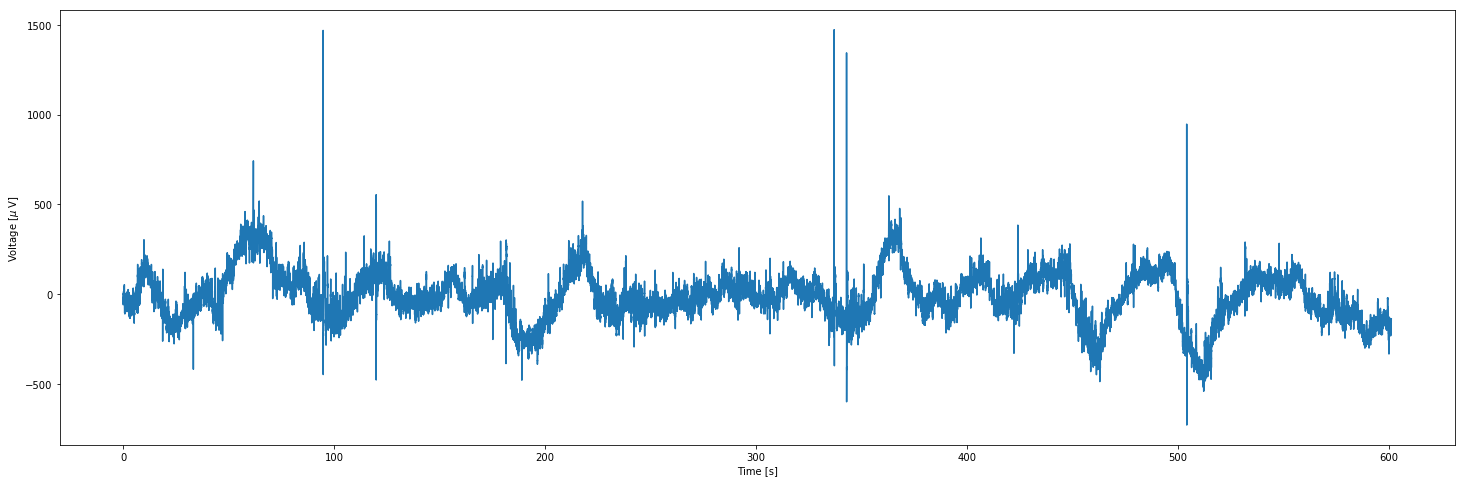

In [7]:
fig, ax = plt.subplots(figsize=(25, 8))
t = np.linspace(0, df.shape[1]/sampling_freq, df.shape[1]);
plt.xlabel("Time [s]");
plt.ylabel(r"Voltage [$\mu$ V]");
plt.plot(t, df.iloc[idx]);

In [8]:
values = df.values

## Test the filter powerline filter

First we show the signal spectrum without any preprocessing. 

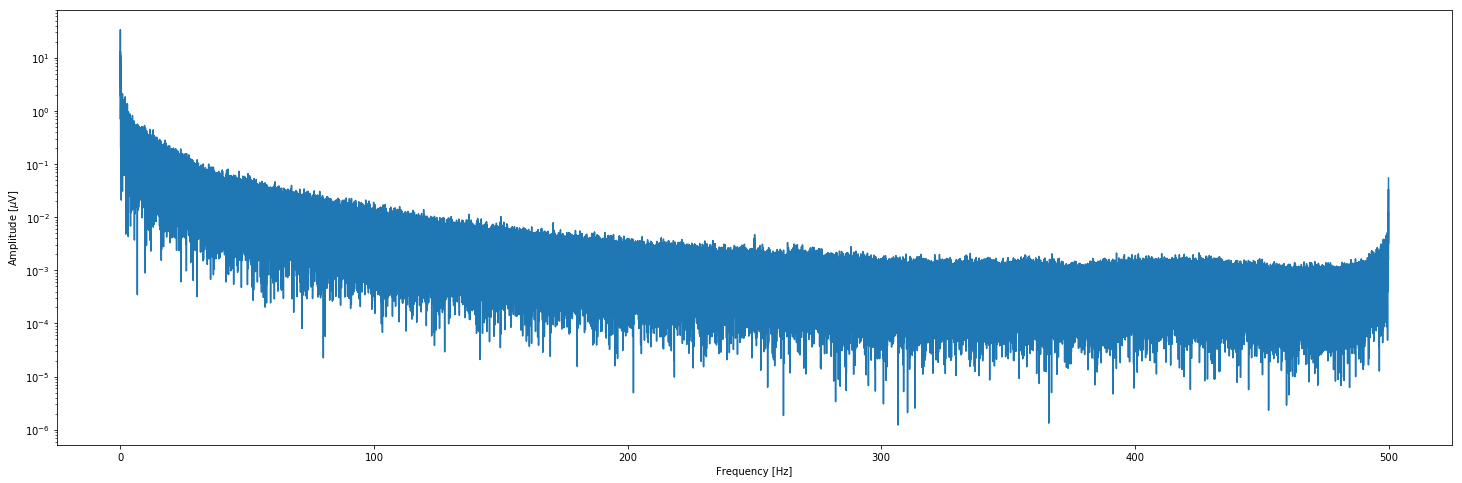

In [11]:
n, T = values.shape

fft_values = (1./T) * fft(values, axis=-1)
freqs = fftfreq(d=1/sampling_freq, n=values.shape[1])

fig, ax = plt.subplots(figsize=(25, 8));
plt.semilogy(freqs[:T/2], np.abs(fft_values[idx][:T/2]));
plt.xlabel("Frequency [Hz]");
plt.ylabel(r"Amplitude [$\mu$V]");

Here we show the result of the powerline filter f=50 Hz and all the harmonics. 

/home/vanessa/miniconda2/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


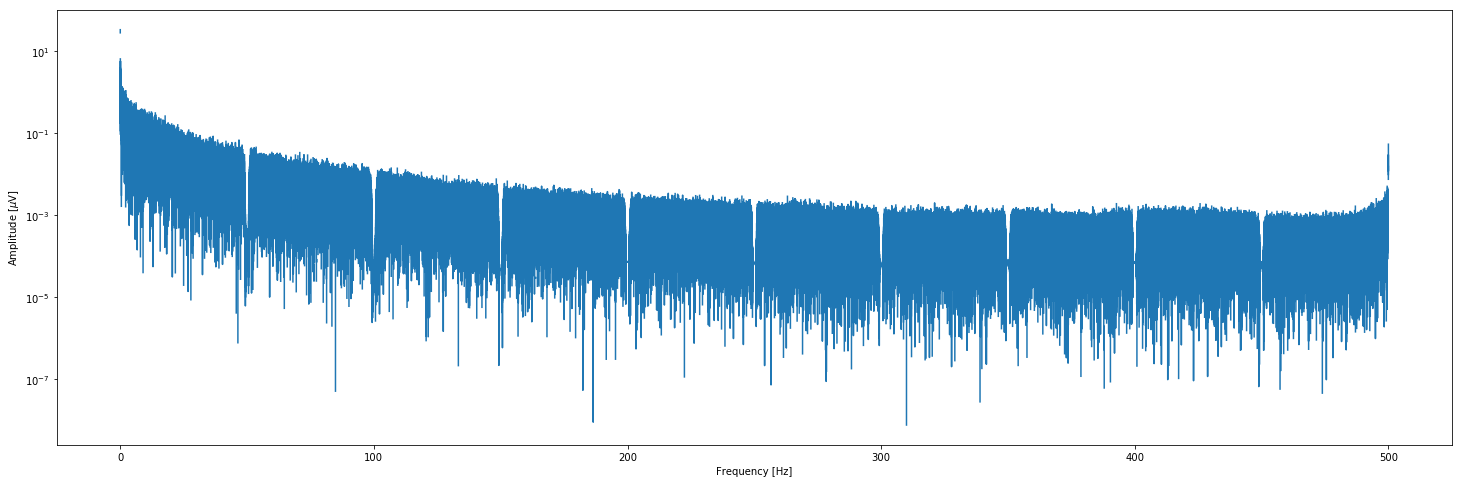

In [12]:
PreProcess = PreProcessing(fs=sampling_freq);
values = PreProcess.remove_powerline(values);

fft_values = (1./T) * fft(values, axis=-1)

fig, ax = plt.subplots(figsize=(25, 8));
plt.semilogy(freqs[:T/2], fft_values[idx][:T/2]);
plt.xlabel("Frequency [Hz]");
plt.ylabel(r"Amplitude [$\mu$V]");

## Wavelet transform

Here we compute the continuous wavelet transform. We show the example with one scale, but in the code we use all the possible scales, which are **WaveletTransf.nscales**

**remove_edges** rm the edges on both sides, 10 s of activity

In [14]:
central_freqs  # values for the central frequency

array([476.19047619, 441.86147805, 410.00728814, 380.44949534,
       353.0225503 , 327.5728383 , 303.95781885, 282.04522731,
       261.71233414, 242.84525745, 225.33832523, 209.09348344,
       194.01974685, 180.03268944, 167.05397153, 155.01090102,
       143.83602626, 133.46675824, 123.84502004, 114.91692157,
       106.63245771,  98.94522828,  91.81217811,  85.19335592,
        79.05169055,  73.35278334,  68.06471546,  63.15786913,
        58.60476175,  54.37989196,  50.45959682,  46.82191926,
        43.44648515,  40.3143891 ,  37.40808867,  34.71130603,
        32.20893688,  29.88696575,  27.73238761,  25.73313494,
        23.87801018,  22.15662303,  20.55933222,  19.07719154,
        17.7018997 ,  16.42575389,  15.24160657,  14.1428255 ,
        13.12325654,  12.17718921,  11.29932473,  10.48474628,
         9.72889153,   9.02752702,   8.37672451,   7.77283893,
         7.21248801,   6.69253328,   6.21006256,   5.76237359,
         5.34695891,   4.96149185,   4.60381346,   4.27

Number of scales: 83
Central frequency: 107.0
Shape of the original data matrix: (139, 601000)
Shape after removing the edges: (139, 581000)


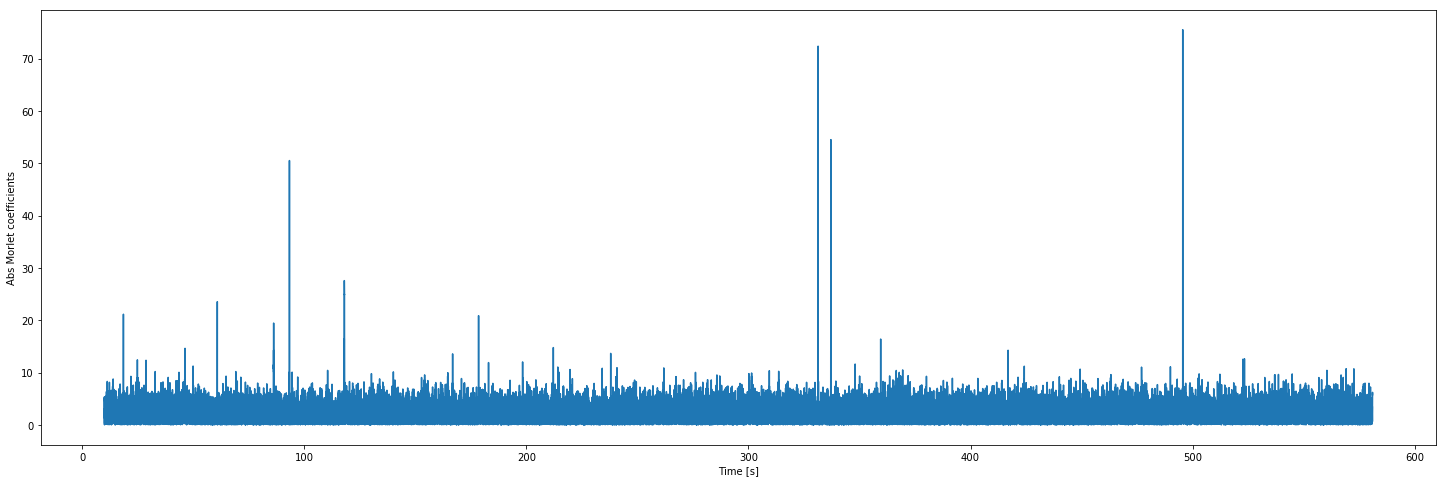

In [25]:
WaveletTransf = CWTTransform(fs=sampling_freq)
central_freqs = WaveletTransf.freqs
scale = 20

print("Number of scales: " + str(WaveletTransf.nscales))
print("Central frequency: " + str(np.round(central_freqs[scale])))

print("Shape of the original data matrix: " + str(values.shape))

cwt_coefs = WaveletTransf.cwt(values, scale)
    
# we want to remove the edges, after all the filtering part
cwt_coefs = remove_edges(cwt_coefs)
t0 = 10  # we remove the first ten seconds because of artifacts - starting point of the acquisition
t = np.linspace(t0, (cwt_coefs.shape[1]+t0)/sampling_freq, cwt_coefs.shape[1])

print("Shape after removing the edges: " + str(cwt_coefs.shape))
    
plt.figure(figsize=(25, 8))
plt.plot(t, np.abs(cwt_coefs[0]))
plt.xlabel("Time [s]")
plt.ylabel("Abs Morlet coefficients")
plt.show()

In [26]:
correlation_matrix = correlation(np.abs(cwt_coefs))
crosscorr_matrix = fourier_corr(np.abs(cwt_coefs))
plv_matrix = phaselockingvalue(cwt_coefs)

## Plot of similarity measures for all the dataset at a fixed scale

Here we show the three different kernels for the central frequency defined above

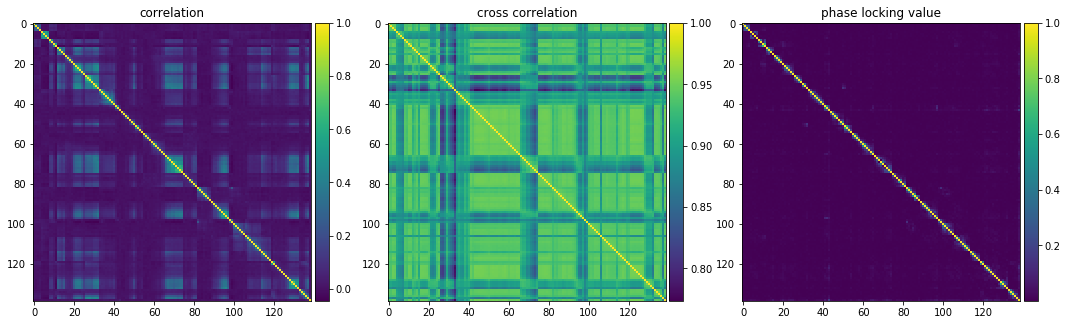

In [27]:
fig, ax = plt.subplots(figsize=(18, 6), nrows=1, ncols=3)

img0 = ax[0].imshow(correlation_matrix);
div = make_axes_locatable(ax[0])
cax0 = div.append_axes("right", size="5%", pad=0.05)
ax[0].set_title("correlation");
fig.colorbar(img0, cax=cax0)

img1 = ax[1].imshow(crosscorr_matrix);
div = make_axes_locatable(ax[1])
cax1 = div.append_axes("right", size="5%", pad=0.05)
ax[1].set_title("cross correlation");
fig.colorbar(img1, cax=cax1);

img2 = ax[2].imshow(plv_matrix);
div = make_axes_locatable(ax[2]);
cax2 = div.append_axes("right", size="5%", pad=0.05);
ax[2].set_title("phase locking value");
fig.colorbar(img2, cax=cax2);